# Forecasting QQQ with its Own Options Data


## Use SQL to filter the dataset and import the dataset into Pandas

In [441]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('my_database.db')

In [ ]:
chunksize = 500_000  # adjust based on your RAM
for chunk in pd.read_csv('options_eod_QQQ.csv', chunksize=chunksize):
    chunk.to_sql('options_eod_QQQ', conn, if_exists='append', index=False)

for chunk in pd.read_csv('options_eod_SPY.csv', chunksize=chunksize):
    chunk.to_sql('options_eod_SPY', conn, if_exists='append', index=False)


In [ ]:
conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()

In [442]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [445]:
%%sql sqlite:///my_database.db
SELECT *
FROM options_eod_QQQ
where strike < spotPrice
LIMIT 5;

Done.


tradeDate,spotPrice,stockPrice,expirDate,dte,strike,delta,gamma,vega,theta,rho,callValue,callBidPrice,callAskPrice,callOpenInterest,callVolume,putValue,putBidPrice,putAskPrice,putOpenInterest,putVolume
2020-01-02,215.62,215.62,2020-01-03,2,165.0,0.9999999999999788,-1.266410750210431e-13,-3.5287386486315014e-12,-0.009870576224957,0.0045641699028532,50.629966720951046,50.5,50.75,6,0,0.0,0.0,0.01,39,0
2020-01-02,215.62,215.62,2020-01-03,2,165.5,0.9999999999999784,-1.8767680065710554e-13,-3.0582401621473014e-12,-0.0099004870620584,0.004578000719496,50.12999692313576,50.0,50.25,4,0,0.0,0.0,0.01,0,0
2020-01-02,215.62,215.62,2020-01-03,2,166.0,0.9999999999999788,-6.560534938498056e-14,-3.0582401621473014e-12,-0.0099303978991598,0.0045918315408061,49.630027125320446,49.5,49.75,0,0,0.0,0.0,0.01,1,0
2020-01-02,215.62,215.62,2020-01-03,2,166.5,0.999999999999968,-1.266410750210431e-13,-3.2934894053894016e-12,-0.0099603087360826,0.0046056623527817,49.13005732750515,49.0,49.25,0,0,0.0,0.0,0.01,1,0
2020-01-02,215.62,215.62,2020-01-03,2,167.0,0.999999999999968,-1.266410750210431e-13,-3.0582401621473014e-12,-0.009990219573184,0.004619493172536,48.63008752968985,48.5,48.75,0,0,0.0,0.0,0.01,0,0


In [4]:
%%sql result_qqq <<
SELECT *
FROM options_eod_QQQ
WHERE strike BETWEEN 0.8 * spotPrice AND 1.2 * spotPrice
  AND (callVolume + putVolume) > 0
  AND (callOpenInterest + putOpenInterest) > 0
ORDER BY tradeDate, strike;


 * sqlite:///my_database.db
Done.
Returning data to local variable result_qqq


In [5]:
%%sql result_spy <<
SELECT *
FROM options_eod_SPY
WHERE strike BETWEEN 0.8 * spotPrice AND 1.2 * spotPrice
  AND (callVolume + putVolume) > 0
  AND (callOpenInterest + putOpenInterest) > 0
ORDER BY tradeDate, strike;


 * sqlite:///my_database.db
Done.
Returning data to local variable result_spy


In [6]:
data_qqq = result_qqq.DataFrame()
data_spy = result_spy.DataFrame()

print(data_qqq.shape, data_spy.shape)
print(data_qqq.head())


(5616734, 21) (6789712, 21)
    tradeDate  spotPrice  stockPrice   expirDate  dte  strike     delta  \
0  2020-01-02     215.62      215.62  2020-02-21   51   173.0  0.984934   
1  2020-01-02     215.62      215.62  2020-03-20   79   173.0  0.965183   
2  2020-01-02     215.62      215.62  2020-06-19  170   173.0  0.916562   
3  2020-01-02     215.62      215.62  2020-02-21   51   173.0  0.984934   
4  2020-01-02     215.62      215.62  2020-03-20   79   173.0  0.965183   

      gamma      vega     theta  ...  callValue  callBidPrice  callAskPrice  \
0  0.001672  0.033485 -0.015810  ...  43.111459         42.95         43.36   
1  0.002791  0.073707 -0.020590  ...  43.588768         43.55         43.67   
2  0.004056  0.229038 -0.021917  ...  45.107077         44.42         45.37   
3  0.001672  0.033485 -0.015810  ...  43.111459         42.95         43.36   
4  0.002791  0.073707 -0.020590  ...  43.588768         43.55         43.67   

   callOpenInterest  callVolume  putValue  put

In [446]:
conn.close()

## Feature engineering

In [8]:

df_qqq = data_qqq.copy()
df_spy = data_spy.copy()


In [9]:
# Remove extreme gamma/vega/theta values
thresholds = {
    'gamma': 10,   
    'vega': 100,
    'theta': 1000
}

for greek, thresh in thresholds.items():
    df_qqq = df_qqq[df_qqq[greek].abs() <= thresh]
    df_spy = df_spy[df_spy[greek].abs() <= thresh]


<Axes: ylabel='vega'>

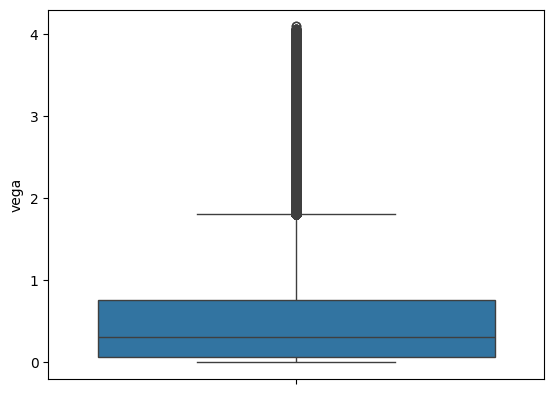

In [35]:
import seaborn as sns

sns.boxplot(df_spy['vega'])

In [472]:
# Calculate IV

from scipy.stats import norm
from scipy.optimize import brentq
import numpy as np

# Black-Scholes call price
def bs_call_price(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def bs_put_price(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)


# Implied volatility for call
def implied_vol_call(C, S, K, T, r=0.05):
    if C <= 0 or T <= 0:
        return np.nan
    try:
        f = lambda sigma: bs_call_price(S, K, T, r, sigma) - C
        return brentq(f, 1e-6, 5)
    except:
        return np.nan

# Implied volatility for put
def implied_vol_put(P, S, K, T, r=0.05):
    if P <= 0 or T <= 0:
        return np.nan
    try:
        f = lambda sigma: bs_put_price(S, K, T, r, sigma) - P
        return brentq(f, 1e-6, 5)
    except:
        return np.nan

In [11]:
# Get atm_qqq and atm_spy

def get_atm_options(df):
    # Find index of option with strike closest to spot for each tradeDate
    atm_idx = df.groupby('tradeDate').apply(
        lambda x: (x['strike'] - x['spotPrice']).abs().idxmin()
    )
    return df.loc[atm_idx.values]
    
atm_qqq = get_atm_options(df_qqq)
atm_spy = get_atm_options(df_spy)


C:\Users\41965\AppData\Local\Temp\ipykernel_11740\1315175646.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  atm_idx = df.groupby('tradeDate').apply(
C:\Users\41965\AppData\Local\Temp\ipykernel_11740\1315175646.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  atm_idx = df.groupby('tradeDate').apply(


In [473]:
def compute_atm_iv(df, iv_call_func):
    """
    Compute ATM IV for each trade date.
    df: option-level dataframe (must contain callBidPrice, callAskPrice, strike, spotPrice, dte)
    """
    result = []

    for date, group in df.groupby("tradeDate"):
        # --- ATM option ---
        atm_row = group.loc[(group['strike'] - group['spotPrice']).abs().idxmin()]
        callMid = (atm_row['callBidPrice'] + atm_row['callAskPrice']) / 2
        T_atm = atm_row['dte'] / 252

        atm_iv = iv_call_func(callMid, atm_row['spotPrice'], atm_row['strike'], T_atm)

        result.append({
            "tradeDate": date,
            "ATM_IV": atm_iv,
            "stockPrice": atm_row['spotPrice']
        })

    return pd.DataFrame(result)

iv_qqq = compute_atm_iv(df_qqq, implied_vol_call)
iv_spy = compute_atm_iv(df_spy, implied_vol_call)


In [475]:
iv_qqq.head()

,tradeDate,ATM_IV,stockPrice
0,2020-01-02,0.069316,215.62
1,2020-01-03,0.028436,214.56
2,2020-01-06,0.107343,215.22
3,2020-01-07,0.098429,215.75
4,2020-01-08,0.088591,217.86


In [14]:
# iv slope function

def iv_slope(df):
    # long DTE and short DTE
    result = df.groupby('tradeDate').apply(
        lambda x: x.loc[x['dte'].idxmax()]['IV'] - x.loc[x['dte'].idxmin()]['IV']
    ).reset_index(name='IV_slope')
    return result


In [15]:
# Aggregate greeks to get net_greeks features with weights
# Calculate call_put_ratio, call_oi, put_oi, call_vol, put_vol

def aggregate_greeks(df):
    g = df.copy()

    # Avoid DTE=0
    g['dte'] = g['dte'].replace(0, 0.5)

    # Weight = OI / DTE
    g['weight'] = (g['callOpenInterest'] + g['putOpenInterest']) / g['dte']

    def wavg(series):
        return np.sum(series * g.loc[series.index, 'weight']) / np.sum(g.loc[series.index, 'weight'])

    out = g.groupby('tradeDate').agg(
        net_delta = ('delta', wavg),
        net_gamma = ('gamma', wavg),
        net_vega  = ('vega',  wavg),
        net_theta = ('theta', wavg),
        call_vol  = ('callVolume','sum'),
        put_vol   = ('putVolume','sum'),
        call_oi   = ('callOpenInterest','sum'),
        put_oi    = ('putOpenInterest','sum'),
    ).reset_index()

    out['call_put_ratio'] = out['call_oi'] / out['put_oi']

    return out


In [16]:
greeks_qqq = aggregate_greeks(df_qqq)
greeks_spy = aggregate_greeks(df_spy)


In [17]:
greeks_spy['net_gamma'].describe()

count    1436.000000
mean        0.021413
std         0.008097
min         0.003679
25%         0.015467
50%         0.019974
75%         0.026220
max         0.057910
Name: net_gamma, dtype: float64

In [476]:
# merge all features into one dataset 
# one tradedate with one row

daily_qqq = iv_qqq.merge(greeks_qqq, on='tradeDate')


In [477]:
daily_spy = (
    iv_spy
    .rename(columns={'ATM_IV': 'ATM_IV_SPY'})
    .merge(greeks_spy, on='tradeDate', suffixes=('', '_spy'))
)


In [478]:
final_df = (
    daily_qqq
    .merge(daily_spy, on='tradeDate', suffixes=('_qqq','_spy'))
)


In [479]:
final_df.set_index('tradeDate', inplace = True)

In [480]:
final_df.head()

,ATM_IV,stockPrice_qqq,net_delta_qqq,net_gamma_qqq,net_vega_qqq,net_theta_qqq,call_vol_qqq,put_vol_qqq,call_oi_qqq,put_oi_qqq,...,stockPrice_spy,net_delta_spy,net_gamma_spy,net_vega_spy,net_theta_spy,call_vol_spy,put_vol_spy,call_oi_spy,put_oi_spy,call_put_ratio_spy
tradeDate,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0.069316,215.62,0.824563,0.030746,0.060542,-0.048134,642519,1149030,4645305,6837411,...,324.10,0.770859,0.040812,0.094648,-0.066114,1845958,2423082,11049638,16324590,0.676871
2020-01-03,0.028436,214.56,0.743774,0.053381,0.041262,-0.151453,889476,1426245,4721976,7305981,...,322.77,0.664462,0.057245,0.069734,-0.215371,2258372,3478624,10503148,16989106,0.618228
2020-01-06,0.107343,215.22,0.779153,0.029654,0.074868,-0.059611,602661,1021452,4458390,6987681,...,323.17,0.707585,0.049909,0.081857,-0.084566,1690790,2679004,10300886,16611014,0.620124
2020-01-07,0.098429,215.75,0.790888,0.033205,0.067984,-0.064484,482709,656562,4768974,7436346,...,323.05,0.685552,0.037004,0.099908,-0.084292,1650426,1750898,10739336,16788424,0.639687
2020-01-08,0.088591,217.86,0.842531,0.027225,0.053658,-0.057969,835335,1322835,4857582,7603968,...,325.38,0.809836,0.043441,0.068694,-0.099472,2549652,2796406,11572708,17113968,0.676214


In [481]:
# Some more features that are possiblly useful

final_df["iv_chg"] = final_df["ATM_IV"].diff()
final_df["ivov_10"] = final_df["ATM_IV"].rolling(10).std()


final_df["gamma_ratio"] = final_df["net_gamma_spy"] / final_df["net_gamma_qqq"]
final_df["delta_ratio"] = final_df["net_delta_spy"] / final_df["net_delta_qqq"]
final_df["vega_ratio"] = final_df["net_vega_spy"] / final_df["net_vega_qqq"]

final_df["vega_chg"] = final_df["net_vega_qqq"].diff()

final_df["ret"] = final_df["stockPrice_qqq"].pct_change()
final_df["rv_5"] = final_df["ret"].rolling(5).std() * np.sqrt(252)
final_df["vol_premium"] = final_df["ATM_IV"] - final_df["rv_5"]


final_df["pc_oi"] = final_df["put_oi_qqq"] / final_df["call_oi_qqq"]

final_df["call_spike"] = final_df["call_vol_qqq"] / final_df["call_vol_qqq"].rolling(20).mean()
final_df["put_spike"] = final_df["put_vol_qqq"] / final_df["put_vol_qqq"].rolling(20).mean()


In [482]:
# Simple returns
final_df["mom_5"] = final_df["stockPrice_qqq"].pct_change(5)
final_df["mom_20"] = final_df["stockPrice_qqq"].pct_change(20)

# Simple Moving Averages
final_df["sma_5"] = final_df["stockPrice_qqq"].rolling(5).mean()
final_df["sma_20"] = final_df["stockPrice_qqq"].rolling(20).mean()
final_df["sma_ratio"] = final_df["sma_5"] / final_df["sma_20"]


#### Define target column

In [483]:
# Define target_return as qqq_return / 

final_df["QQQ_return"] = final_df["stockPrice_qqq"].pct_change()
final_df["vola_5"] = final_df["QQQ_return"].rolling(5).std()

final_df['target_return'] = (final_df['QQQ_return'].shift(-1))/ final_df['vola_5']



In [484]:
# The range of the target is scaled from -1 to 1.5

import numpy as np
final_df["target"] = np.where(
    final_df["target_return"] >= 0,
    1.5 * np.tanh(final_df["target_return"]),   # positive side scaled to +1.5
    1.0 * np.tanh(final_df["target_return"])    # negative side scaled to -1
)


final_df.head()

,ATM_IV,stockPrice_qqq,net_delta_qqq,net_gamma_qqq,net_vega_qqq,net_theta_qqq,call_vol_qqq,put_vol_qqq,call_oi_qqq,put_oi_qqq,...,put_spike,mom_5,mom_20,sma_5,sma_20,sma_ratio,QQQ_return,vola_5,target_return,target
tradeDate,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0.069316,215.62,0.824563,0.030746,0.060542,-0.048134,642519,1149030,4645305,6837411,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,0.028436,214.56,0.743774,0.053381,0.041262,-0.151453,889476,1426245,4721976,7305981,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.004916,NaN,NaN,NaN
2020-01-06,0.107343,215.22,0.779153,0.029654,0.074868,-0.059611,602661,1021452,4458390,6987681,...,NaN,NaN,NaN,NaN,NaN,NaN,0.003076,NaN,NaN,NaN
2020-01-07,0.098429,215.75,0.790888,0.033205,0.067984,-0.064484,482709,656562,4768974,7436346,...,NaN,NaN,NaN,NaN,NaN,NaN,0.002463,NaN,NaN,NaN
2020-01-08,0.088591,217.86,0.842531,0.027225,0.053658,-0.057969,835335,1322835,4857582,7603968,...,NaN,NaN,NaN,215.802,NaN,NaN,0.009780,NaN,NaN,NaN


In [485]:
final_df.columns

Index(['ATM_IV', 'stockPrice_qqq', 'net_delta_qqq', 'net_gamma_qqq',
       'net_vega_qqq', 'net_theta_qqq', 'call_vol_qqq', 'put_vol_qqq',
       'call_oi_qqq', 'put_oi_qqq', 'call_put_ratio_qqq', 'ATM_IV_SPY',
       'stockPrice_spy', 'net_delta_spy', 'net_gamma_spy', 'net_vega_spy',
       'net_theta_spy', 'call_vol_spy', 'put_vol_spy', 'call_oi_spy',
       'put_oi_spy', 'call_put_ratio_spy', 'iv_chg', 'ivov_10', 'gamma_ratio',
       'delta_ratio', 'vega_ratio', 'vega_chg', 'ret', 'rv_5', 'vol_premium',
       'pc_oi', 'call_spike', 'put_spike', 'mom_5', 'mom_20', 'sma_5',
       'sma_20', 'sma_ratio', 'QQQ_return', 'vola_5', 'target_return',
       'target'],
      dtype='object')

## Preprocess dataset

In [486]:
# List of columns to drop
# Dropped columns are highly correlated with other columns

cols_to_drop = [
    'ret', 'vega_chg', 'call_put_ratio_qqq',
    'call_put_ratio_spy', 'target_return', 'ivov_10', 'vola_5'
]

# Drop them from the dataframe
df_model = final_df.drop(columns=cols_to_drop)

# Check remaining columns
print(df_model.columns)

Index(['ATM_IV', 'stockPrice_qqq', 'net_delta_qqq', 'net_gamma_qqq',
       'net_vega_qqq', 'net_theta_qqq', 'call_vol_qqq', 'put_vol_qqq',
       'call_oi_qqq', 'put_oi_qqq', 'ATM_IV_SPY', 'stockPrice_spy',
       'net_delta_spy', 'net_gamma_spy', 'net_vega_spy', 'net_theta_spy',
       'call_vol_spy', 'put_vol_spy', 'call_oi_spy', 'put_oi_spy', 'iv_chg',
       'gamma_ratio', 'delta_ratio', 'vega_ratio', 'rv_5', 'vol_premium',
       'pc_oi', 'call_spike', 'put_spike', 'mom_5', 'mom_20', 'sma_5',
       'sma_20', 'sma_ratio', 'QQQ_return', 'target'],
      dtype='object')


In [487]:
# drop rows with missing values in target or iv_chg

df_model = df_model.dropna(subset = ['target', 'iv_chg', 'mom_20'])
print(df_model['target'].isna().sum())

0


In [488]:
df_model.isna().sum()

ATM_IV             0
stockPrice_qqq     0
net_delta_qqq      0
net_gamma_qqq      0
net_vega_qqq       0
net_theta_qqq      0
call_vol_qqq       0
put_vol_qqq        0
call_oi_qqq        0
put_oi_qqq         0
ATM_IV_SPY        17
stockPrice_spy     0
net_delta_spy      0
net_gamma_spy      0
net_vega_spy       0
net_theta_spy      0
call_vol_spy       0
put_vol_spy        0
call_oi_spy        0
put_oi_spy         0
iv_chg             0
gamma_ratio        0
delta_ratio        0
vega_ratio         0
rv_5               0
vol_premium        0
pc_oi              0
call_spike         0
put_spike          0
mom_5              0
mom_20             0
sma_5              0
sma_20             0
sma_ratio          0
QQQ_return         0
target             0
dtype: int64

In [489]:
# forward fill the rest of missing values

cols_to_forwardfill = ['ATM_IV_SPY']
df_model[cols_to_forwardfill] = df_model[cols_to_forwardfill].ffill()


In [388]:
df_model.columns

Index(['stockPrice_qqq', 'ATM_IV', 'net_delta_qqq', 'net_gamma_qqq',
       'net_vega_qqq', 'net_theta_qqq', 'call_vol_qqq', 'put_vol_qqq',
       'call_oi_qqq', 'put_oi_qqq', 'stockPrice_spy', 'ATM_IV_SPY',
       'net_delta_spy', 'net_gamma_spy', 'net_vega_spy', 'net_theta_spy',
       'call_vol_spy', 'put_vol_spy', 'call_oi_spy', 'put_oi_spy', 'iv_chg',
       'gamma_ratio', 'delta_ratio', 'vega_ratio', 'rv_5', 'vol_premium',
       'pc_oi', 'call_spike', 'put_spike', 'mom_5', 'mom_20', 'sma_5',
       'sma_20', 'sma_ratio', 'QQQ_return', 'target'],
      dtype='object')

## Create training set, validation set and pca + ridge model

In [490]:
# split training set and test set
from sklearn.model_selection import train_test_split

X = df_model.drop(columns=['target'])
y = df_model['target']



In [312]:
# split without shuffling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(len(X_train), len(X_test))


1108 277


In [313]:
abnormal_features = [
        'ATM_IV',          # QQQ implied volatility
        'ATM_IV_SPY',      # SPY implied volatility
        'iv_chg',          # Change in IV
        'vol_premium',     # IV - RV
        'call_vol_qqq',    # QQQ call volume
        'put_vol_qqq',     # QQQ put volume
        'call_oi_qqq',     # QQQ call open interest
        'put_oi_qqq',      # QQQ put open interest
        'pc_oi',           # Put-call open interest ratio
        'call_spike',      # Spike in call volume
        'put_spike',       # Spike in put volume
        'net_gamma_qqq',   # QQQ gamma exposure
        'net_delta_qqq',   # QQQ delta exposure
        'rv_5'             # 5-day realized volatility
    ]


### Create 'abnormality_score' feature

In [492]:
# Calculate median based on training set
med_train = X_train[abnormal_features].median()
mad_train = (X_train[abnormal_features] - med_train).abs().median()
mad_train = mad_train.replace(0, 1e-6)

X_train_z = (X_train[abnormal_features] - med_train) / (1.4826 * mad_train)
X_test_z  = (X_test[abnormal_features]  - med_train) / (1.4826 * mad_train)


In [493]:
X_train["ab_score"] = X_train_z.abs().sum(axis=1)
X_test["ab_score"]  = X_test_z.abs().sum(axis=1)

In [356]:
X_train.columns

Index(['stockPrice_qqq', 'ATM_IV', 'net_delta_qqq', 'net_gamma_qqq',
       'net_vega_qqq', 'net_theta_qqq', 'call_vol_qqq', 'put_vol_qqq',
       'call_oi_qqq', 'put_oi_qqq', 'stockPrice_spy', 'ATM_IV_SPY',
       'net_delta_spy', 'net_gamma_spy', 'net_vega_spy', 'net_theta_spy',
       'call_vol_spy', 'put_vol_spy', 'call_oi_spy', 'put_oi_spy', 'iv_chg',
       'gamma_ratio', 'delta_ratio', 'vega_ratio', 'rv_5', 'vol_premium',
       'pc_oi', 'call_spike', 'put_spike', 'mom_5', 'mom_20', 'sma_5',
       'sma_20', 'sma_ratio', 'QQQ_return', 'ab_score'],
      dtype='object')

In [494]:
# Use pipeline to build the ridge model with weights on abnormal cases (top 20% most extreme days)
# Use gridsearch to find the best parameters

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV


tscv = TimeSeriesSplit(n_splits=5)

pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', PCA()),
    ('model', Ridge())  # or Lasso()
])

params = {
        'pca__n_components': [0.5, 0.6, 0.7, 0.8, 0.9],
        'model__alpha': [ 0.1, 1, 10, 100]
}

grid = GridSearchCV(
    pipe,
    params,
    cv=tscv,
    scoring= 'neg_mean_absolute_error',
    n_jobs=-1
)

weights = np.where(X_train['ab_score'] > np.percentile(X_train['ab_score'], 80), 500, 1) 

grid.fit(X_train, y_train, model__sample_weight = weights)
best = grid.best_estimator_

print("Best params_:", grid.best_params_)
print("Best score_:", -grid.best_score_)



Best params_: {'model__alpha': 100, 'pca__n_components': 0.7}
Best score_: 0.7216801371586968


In [495]:
y_test_pred = best.predict(X_test)
y_train_pred = best.predict(X_train)

In [499]:
# # This is another model with worse performance
# # Threshold to separate normal vs abnormal
# threshold = np.percentile(X_train['ab_score'], 80)

# # Boolean masks
# mask_train_normal   = X_train['ab_score'] <= threshold
# mask_train_abnormal = X_train['ab_score'] > threshold

# mask_test_normal    = X_test['ab_score'] <= threshold
# mask_test_abnormal  = X_test['ab_score'] > threshold

# # Training subsets
# X_train_normal   = X_train.loc[mask_train_normal].drop(columns=['ab_score'])
# y_train_normal   = y_train.loc[mask_train_normal]

# X_train_abnormal = X_train.loc[mask_train_abnormal].drop(columns=['ab_score'])
# y_train_abnormal = y_train.loc[mask_train_abnormal]

# # Similarly for X_test
# X_test_normal    = X_test.loc[mask_test_normal].drop(columns=['ab_score'])
# X_test_abnormal  = X_test.loc[mask_test_abnormal].drop(columns=['ab_score'])

# y_test_normal   = y_test.loc[mask_test_normal]
# y_test_abnormal = y_test.loc[mask_test_abnormal]


In [500]:
# # Use gridsearch to find the best parameters

# from sklearn.preprocessing import RobustScaler
# from sklearn.decomposition import PCA
# from sklearn.linear_model import Ridge
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import TimeSeriesSplit, GridSearchCV


# tscv = TimeSeriesSplit(n_splits=5)

# pipe = Pipeline([
#     ('scaler', RobustScaler()),
#     ('pca', PCA()),
#     ('model', Ridge())  # or Lasso()
# ])

# params = {
#         'pca__n_components': [0.5, 0.6, 0.7, 0.8, 0.9],
#         'model__alpha': [ 0.1, 1, 10, 100]
# }

# grid_normal = GridSearchCV(
#     pipe,
#     params,
#     cv=tscv,
#     scoring= 'neg_mean_absolute_error',
#     n_jobs=-1
# )

# grid_normal.fit(X_train_normal, y_train_normal)
# best_normal = grid_normal.best_estimator_
# print("Best params_normal:", grid_normal.best_params_)
# print("Best score_normal:", -grid_normal.best_score_)

# grid_abnormal = GridSearchCV(
#     pipe,
#     params,
#     cv=tscv,
#     scoring= 'neg_mean_absolute_error',
#     n_jobs=-1
# )

# grid_abnormal.fit(X_train_abnormal, y_train_abnormal)
# best_abnormal = grid_abnormal.best_estimator_

# print("Best params_abnormal:", grid_abnormal.best_params_)
# print("Best score_abnormal:", -grid_abnormal.best_score_)



In [501]:
# # Initialize predictions
# y_test_pred = pd.Series(index=X_test.index, dtype=float)
# y_train_pred = pd.Series(index=X_train.index, dtype=float)

# # Predict normal days
# y_test_pred.loc[mask_test_normal] = best_normal.predict(X_test_normal)
# y_train_pred.loc[mask_train_normal] = best_normal.predict(X_train_normal)

# # Predict abnormal days
# y_test_pred.loc[mask_test_abnormal] = best_abnormal.predict(X_test_abnormal)
# y_train_pred.loc[mask_train_abnormal] = best_abnormal.predict(X_train_abnormal)

# y_test_pred = y_test_pred.sort_index()
# y_train_pred = y_train_pred.sort_index()


## Calculate calmar ratio in the training set and validation set

In [496]:
# calculate strategy returns
returns_for_strategy = df_model.loc[X_train.index, 'QQQ_return'].shift(-1)
signal = pd.Series(y_train_pred, index=returns_for_strategy.index)
strategy_return = signal*returns_for_strategy

In [497]:
cum_returns = (1 + strategy_return).cumprod()
rolling_max = cum_returns.cummax()
drawdown = (cum_returns - rolling_max) / rolling_max
max_drawdown = drawdown.min()  # negative number

days = len(strategy_return)
total_return = cum_returns.iloc[-2]  # ending value
cagr = total_return**(252/days) - 1

calmar_ratio = cagr / abs(max_drawdown)
print("Calmar Ratio:", calmar_ratio)

Calmar Ratio: 1.9579877529825502


In [498]:
returns_for_strategy_val = df_model.loc[X_test.index, 'QQQ_return'].shift(-1)
signal_val = pd.Series(y_test_pred, index=returns_for_strategy_val.index)
strategy_return_val = signal_val*returns_for_strategy_val

cum_returns_val = (1 + strategy_return_val).cumprod()
rolling_max_val = cum_returns_val.cummax()
drawdown_val = (cum_returns_val - rolling_max_val) / rolling_max_val
max_drawdown_val = drawdown_val.min()  

days = len(strategy_return_val)
total_return_val = cum_returns_val.iloc[-2]  # ending value
cagr_val = total_return_val**(252/days) - 1

calmar_ratio = cagr_val / abs(max_drawdown_val)
print("Calmar Ratio:", calmar_ratio)

Calmar Ratio: 2.3376263435831874
